# Build machine learning model 

**Author**: Eric Bastien  
**Last updated**: 2023/03/21

In this notebook, I use  learning model approaches to predict virus-host interactions using signals of co-evolutions. Instead of making it into a Python script, I am using a Jupyter notebook since some of the steps might affect the approach for steps down the line. 

## Setup

Loading modules necessary for training and testing of machine learning model. Also loading my features script:

In [15]:
import pandas as pd
import numpy as np

import joblib

# machine learning (sklearn) import
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


Load data

In [5]:
# load data
data = pd.read_csv('../data/ml_input.csv')

# set index
data = data.set_index('pairs')

# select relevant rows for machine learning model 
ml_input = data[['GCdiff', 'k3dist', 'k6dist', 'Homology']]
print('The dataframe is made of {} rows and {} columns!'.format(ml_input.shape[0], ml_input.shape[1]))
ml_input.head()

The dataframe is made of 8849 rows and 4 columns!


,GCdiff,k3dist,k6dist,Homology
pairs,,,,
Staphylococcus_arlettae:PG-2021_10,-2.742114,0.578449,0.402651,0
Staphylococcus_aureus:PG-2021_10,-2.089694,0.616030,0.433584,0
Staphylococcus_auricularis:PG-2021_10,-6.609046,0.683113,0.479903,0
Staphylococcus_capitis:PG-2021_10,-2.156700,0.453624,0.328484,0
Staphylococcus_caprae:PG-2021_10,-2.849845,0.550319,0.381439,0


In [6]:
# retrieve target
ml_target = data['infection']

# replace categorical values with numbers
ml_target = ml_target.map({'NoInf' : 0, 'Inf': 1})
ml_target.head()

pairs
Staphylococcus_arlettae:PG-2021_10       0
Staphylococcus_aureus:PG-2021_10         1
Staphylococcus_auricularis:PG-2021_10    0
Staphylococcus_capitis:PG-2021_10        1
Staphylococcus_caprae:PG-2021_10         0
Name: infection, dtype: int64

# Pre model analysis

In [8]:
# create correlation matrix
corr_matrix = ml_input.corr().abs()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
upper


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_77843/941714424.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))


,GCdiff,k3dist,k6dist,Homology
GCdiff,NaN,0.02981,0.033174,0.122909
k3dist,NaN,NaN,0.946431,0.179480
k6dist,NaN,NaN,NaN,0.200905
Homology,NaN,NaN,NaN,NaN


The k3 distance and the k6 distance are highly correlated, which is not surprising. I think there is a line of thought
that could justify removing one of those two features, but visually when I did the plot matrix the slight difference
might matter a bit. For now, I think it's fine to keep them. I think if the correlation between the two was higher,
like around 98% and above, then I would remove one of those two features.

## Building the Model

In my previous attempts, the GradientBoostingClassifier was slightly better than the other models. The difference
between the different models is fairly small.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(ml_input, ml_target, random_state = 5, test_size = 0.3, train_size = 0.7)

gbrt = GradientBoostingClassifier(random_state = 10, max_depth = 7, learning_rate = 0.25, loss = 'exponential')
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

print(ml_input.head())
print(ml_target.head())

Accuracy on training set: 0.973
Accuracy on test set: 0.879
                                         GCdiff    k3dist    k6dist  Homology
pairs                                                                        
Staphylococcus_arlettae:PG-2021_10    -2.742114  0.578449  0.402651         0
Staphylococcus_aureus:PG-2021_10      -2.089694  0.616030  0.433584         0
Staphylococcus_auricularis:PG-2021_10 -6.609046  0.683113  0.479903         0
Staphylococcus_capitis:PG-2021_10     -2.156700  0.453624  0.328484         0
Staphylococcus_caprae:PG-2021_10      -2.849845  0.550319  0.381439         0
pairs
Staphylococcus_arlettae:PG-2021_10       0
Staphylococcus_aureus:PG-2021_10         1
Staphylococcus_auricularis:PG-2021_10    0
Staphylococcus_capitis:PG-2021_10        1
Staphylococcus_caprae:PG-2021_10         0
Name: infection, dtype: int64


Next, let's do a cross validation of the model. This is a more thorough way to determine if the model is doing good.
More specifically, I will use shuffle-split cross-validation. This should be a bit redundant since I used the
shuffle-split cross-validation in the grid search (done in another file) to determine the best parameters. In this
case, I am already using the best parameters that were determined.

In [11]:
shuffle_split = ShuffleSplit(test_size = 0.5, train_size = 0.5, n_splits = 10)
scores = cross_val_score(gbrt, ml_input, ml_target, cv = shuffle_split)
print("Cross_validation scores:\n{}".format(scores))
print("Average cross-validation score: {:.3f}".format(scores.mean()))

Cross_validation scores:
[0.86485876 0.86079096 0.86847458 0.86418079 0.86757062 0.8680226
 0.86372881 0.85717514 0.86734463 0.86079096]
Average cross-validation score: 0.864


## Assessing model performance

Text(0.5, 0, 'Feature Importance')

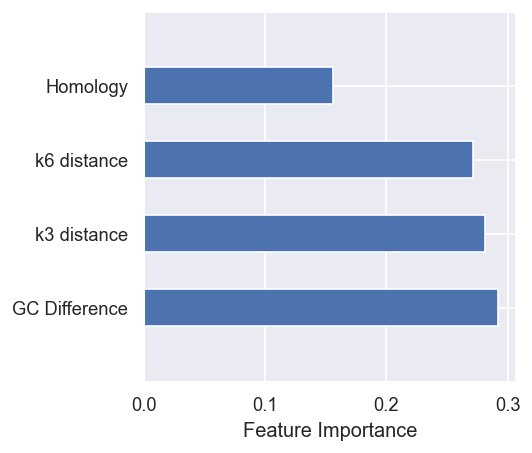

In [13]:
fig = plt.figure(figsize = (4, 4), dpi=120, facecolor='w', edgecolor='k')

features_name = ['GC Difference', 'k3 distance', 'k6 distance', 'Homology']

def plot_feature_importances(model):
    n_features = ml_input.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align = 'center', height=.5)
    plt.yticks(np.arange(n_features), ml_input.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

ax = plt.axes()
#
#plt.style.context('seaborn-whitegrid')

plot_feature_importances(gbrt)


plt.rc('font', family='Helvetica')

plt.ylabel(None)
plt.yticks(np.arange(4), features_name)

plt.xlabel('Feature Importance')

#plt.savefig('../reports/figures/features_importance_VIPmanuscript.png', bbox_inches='tight')
#plt.savefig('../reports/figures/features_importance_VIPmanuscript.pdf', bbox_inches='tight')

## Save model

In [17]:
# Save model as pickle file
joblib.dump(gbrt, 'gbrt.pkl')

['gbrt.pkl']